In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import copy
import matplotlib.pyplot as plt
import numpy as np
import torchvision

### We check whether we train with GPU

In [2]:
print(torch.cuda.is_available())

False


In [3]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the data directory
data_dir = 'D:\images'  # Update this path

# Define transforms for the data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Split the dataset into train, validation, and test sets (70% train, 15% val, 15% test)
train_idx, temp_idx = train_test_split(list(range(len(full_dataset))), test_size=0.3, stratify=full_dataset.targets)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[full_dataset.targets[i] for i in temp_idx])

# Create subsets for each set
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Apply appropriate transforms to each subset
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Create dataloaders for each set
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

# Get dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}


In [4]:
# Get class names
class_names = full_dataset.classes

## Showcasing an array of images and their labels

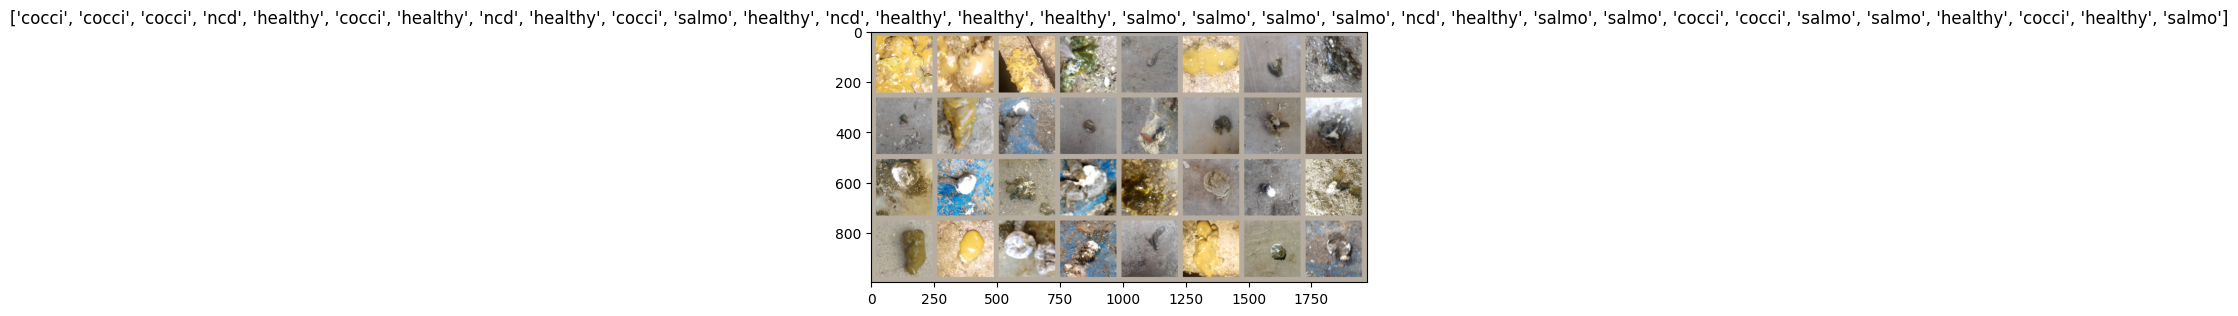

In [5]:
# Define a function to show images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch with larger padding and bigger images
out = torchvision.utils.make_grid(inputs, padding=20, pad_value=1, scale_each=True)

# Display batch with labels
imshow(out, title=[class_names[x] for x in classes])
plt.show()


In [6]:
# Load a pretrained MobileNetV2 model
model_ft = models.mobilenet_v2(pretrained=True)

# Modify the classifier to match the number of classes
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Move the model to the appropriate device
model_ft = model_ft.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

c:\Users\gabrc\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gabrc\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Function to train and validate the model
from tqdm import tqdm

def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            processed_samples = 0

            # Use tqdm to create a progress bar
            with tqdm(dataloaders[phase], unit='batch') as t:
                for inputs, labels in t:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    processed_samples += inputs.size(0)

                    # Update the progress bar description
                    t.set_description(f'{phase} Loss: {running_loss / processed_samples:.4f} Acc: {running_corrects.double() / processed_samples:.4f}')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model


In [8]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer, num_epochs=25)

# Save the model
torch.save(model_ft.state_dict(), 'mobilenet_v2_best.pth')

Epoch 0/24
----------


  0%|          | 0/149 [00:30<?, ?batch/s]


KeyboardInterrupt: 

### Model evaluation

In [9]:
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        with tqdm(total=len(dataloader.dataset), unit=' samples') as progress_bar:
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

                progress_bar.update(inputs.size(0))

    return y_true, y_pred

# Evaluate the model on the test set
y_true, y_pred = evaluate_model(model_ft, dataloaders['test'])

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate classification report
class_names = full_dataset.classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


100%|██████████| 1022/1022 [01:28<00:00, 11.59 samples/s]

Accuracy: 0.3043
Classification Report:
              precision    recall  f1-score   support

       cocci       0.33      0.01      0.01       315
     healthy       0.35      0.93      0.51       309
         ncd       0.11      0.38      0.17        56
       salmo       1.00      0.01      0.01       342

    accuracy                           0.30      1022
   macro avg       0.45      0.33      0.17      1022
weighted avg       0.55      0.30      0.17      1022



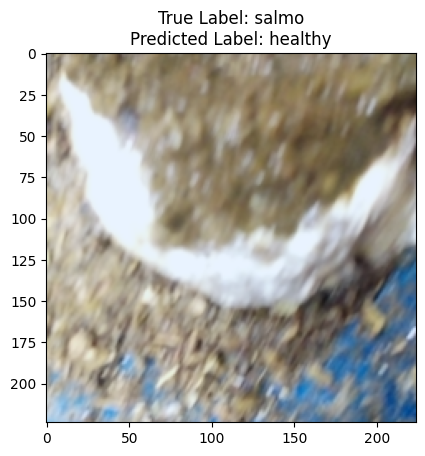

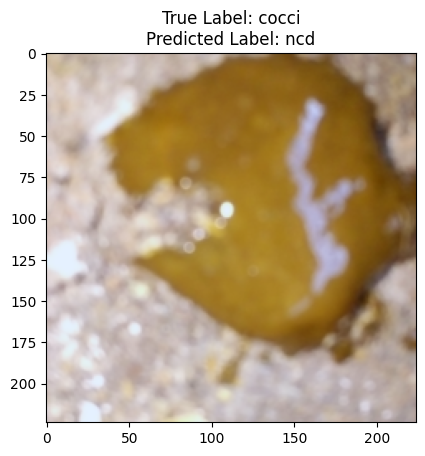

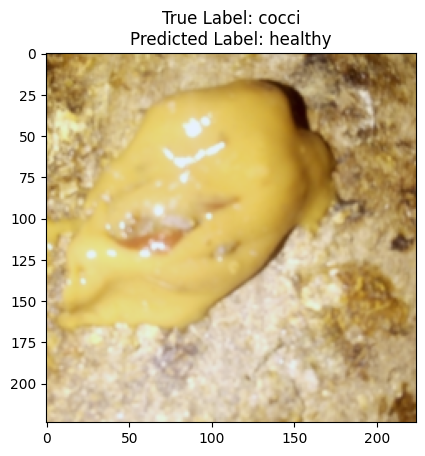

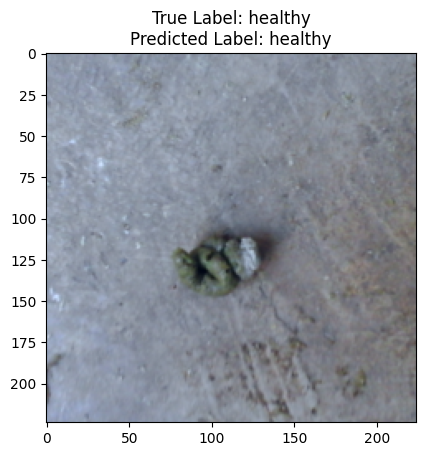

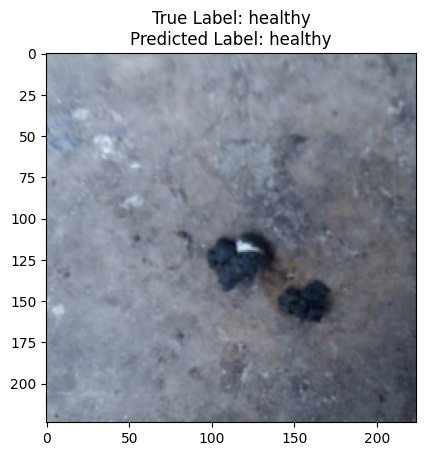

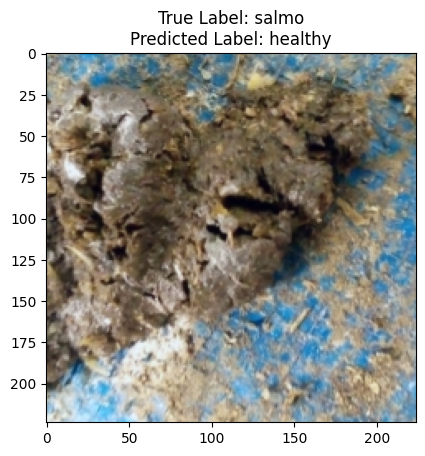

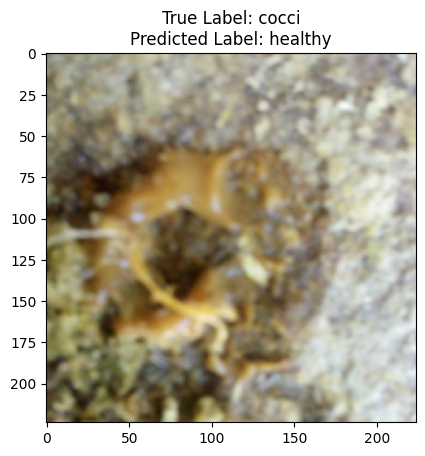

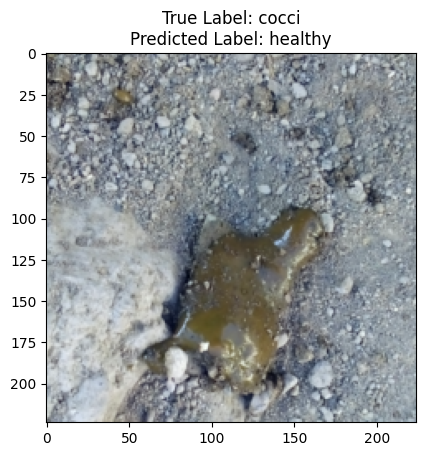

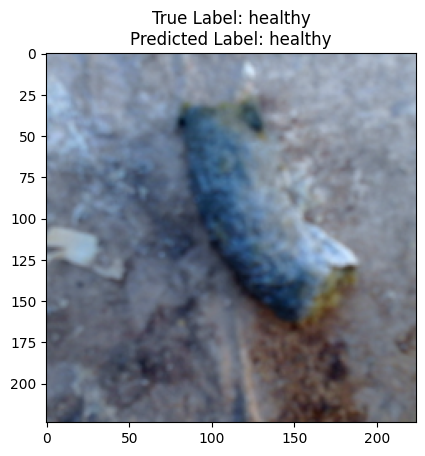

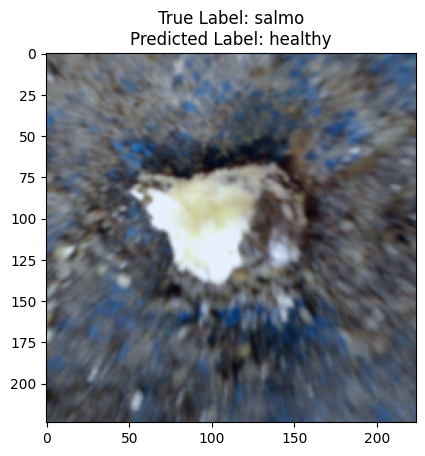

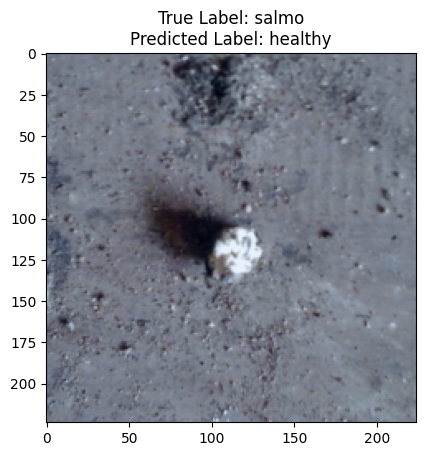

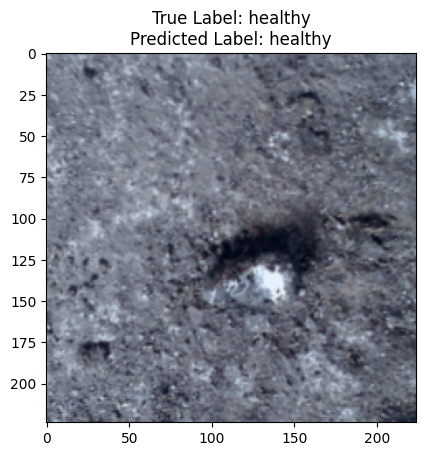

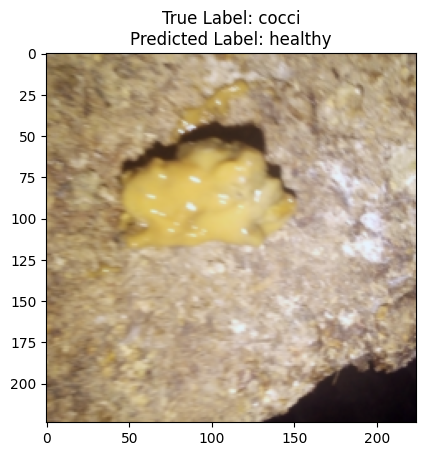

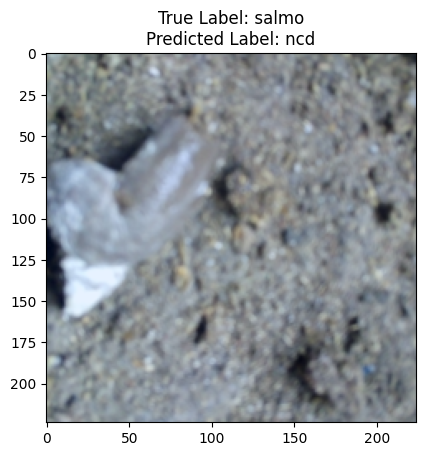

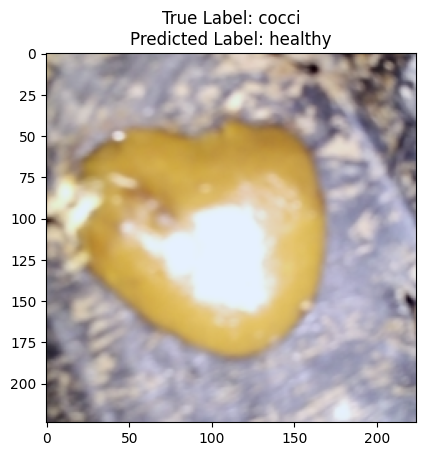

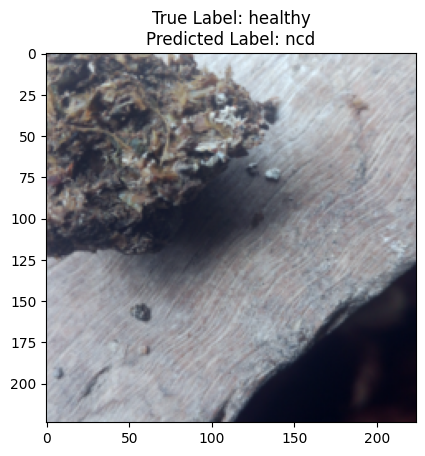

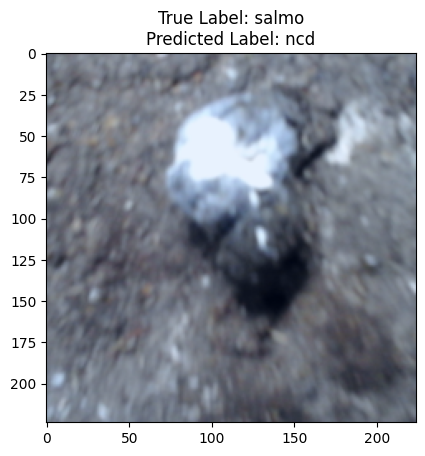

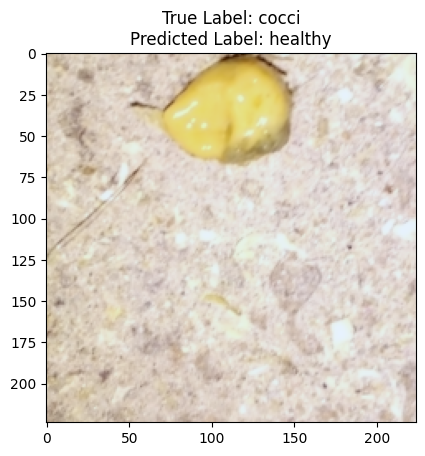

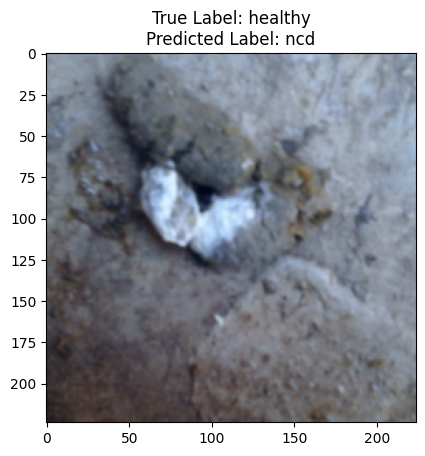

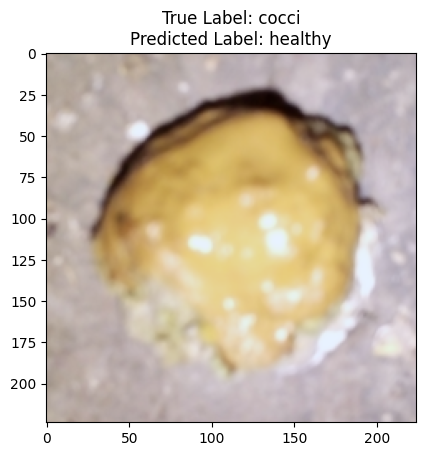

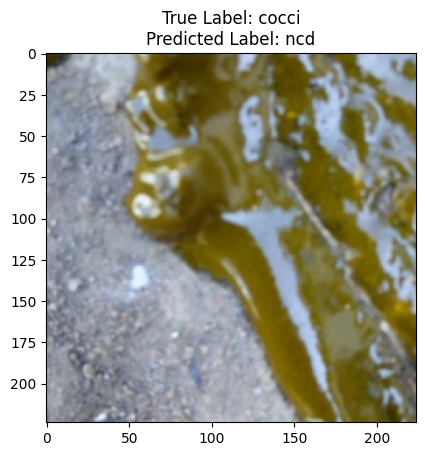

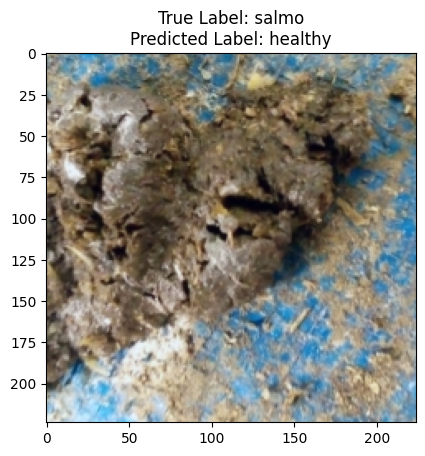

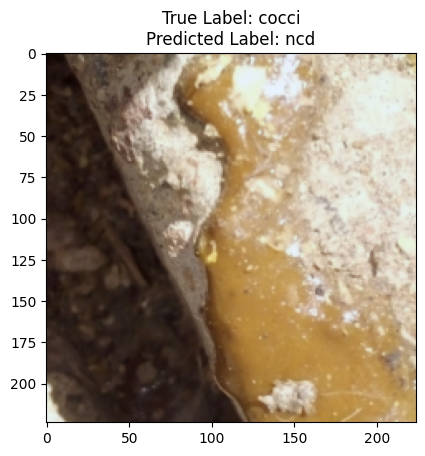

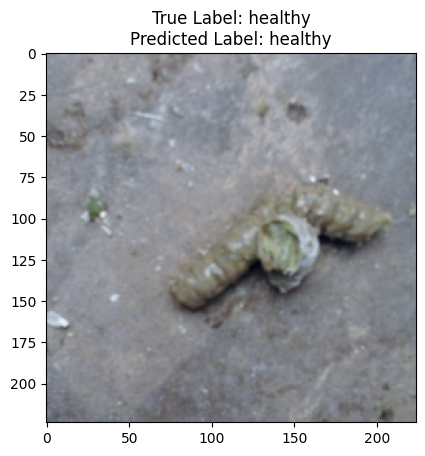

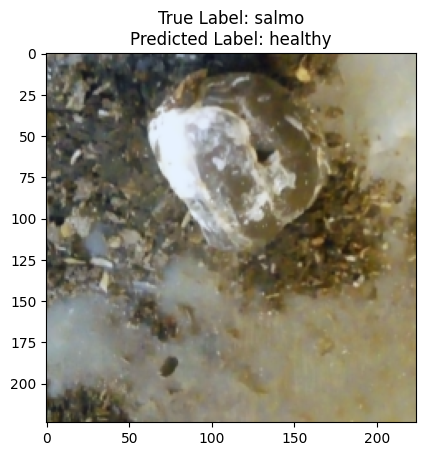

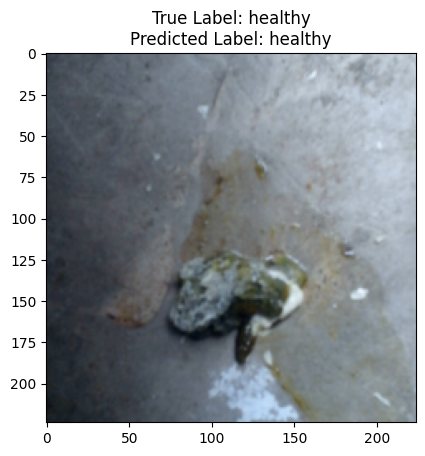

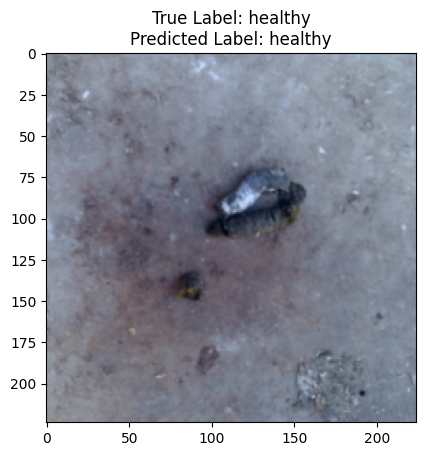

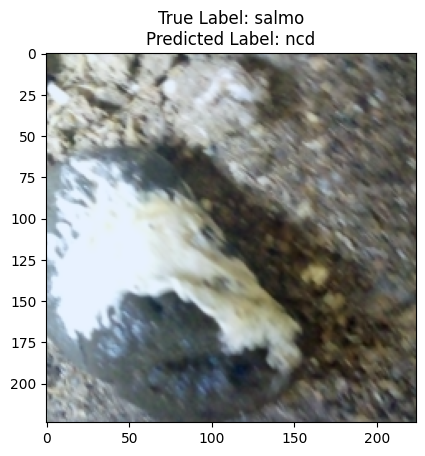

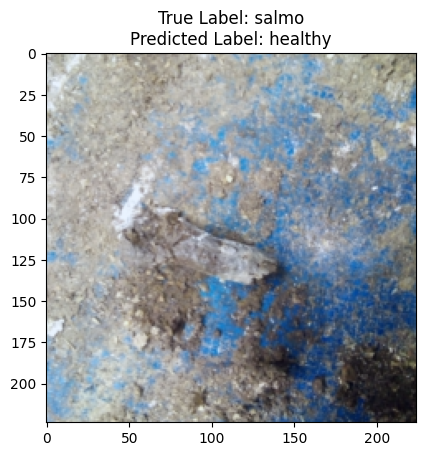

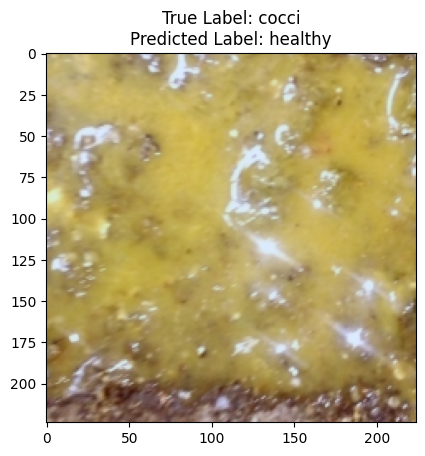

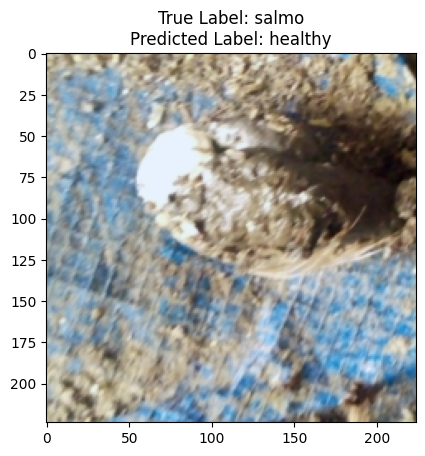

In [10]:
import torch
import matplotlib.pyplot as plt

def show_examples(model, dataloader, class_names, num_examples=1):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if i >= num_examples:
                break

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                true_label = class_names[labels[j]]
                predicted_label = class_names[preds[j]]

                # Normalize image
                input_image = inputs[j].cpu()
                image = input_image.permute(1, 2, 0).numpy()

                # Normalize pixel values to [0, 1]
                image = (image - image.min()) / (image.max() - image.min())

                plt.imshow(image)
                plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
                plt.show()

# Show examples
show_examples(model_ft, dataloaders['test'], class_names, num_examples=1)
